In [1]:
import pandas as pd

In [2]:
predictions = pd.read_csv('submission_2019-3-16_18:19.csv')
predictions['Season'] = pd.to_numeric(predictions['ID'].str.split('_').apply(lambda x: x[0]))
predictions['TeamA'] = pd.to_numeric(predictions['ID'].str.split('_').apply(lambda x: x[1]))
predictions['TeamB'] = pd.to_numeric(predictions['ID'].str.split('_').apply(lambda x: x[2]))
predictions = predictions.drop(columns='ID')
predictions['Season'] = pd.to_numeric(predictions['Season'])

In [3]:
slots = pd.read_csv('DataFiles/NCAATourneySlots.csv')
seeds = pd.read_csv('DataFiles/NCAATourneySeeds.csv')
seeds['SeedNum'] = seeds['Seed'].str.extract('(\d+)').astype(int)
seasons = pd.read_csv('DataFiles/Seasons.csv',index_col='Season')

In [37]:
names = pd.read_csv('DataFiles/Teams.csv',index_col='TeamID')

In [4]:
season = 2018
bracket = seeds[seeds['Season'] == season].set_index('Seed')['TeamID'].to_dict()

In [5]:
pos = [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]
get_pos = {k:v for v,k in sorted([(i+1,p) for i,p in zip(range(16),pos)],key=lambda x: x[1])}

next_pos = dict()
for j in range(4):
    A = sum([2**(4-k) for k in range(j)])
    B = sum([2**(4-k) for k in range(j+1)])
    for i in range(2**(4-j)):
        next_pos[i+1+A] = i//2+1+B

In [88]:
for i,game in slots[slots['Season'] == season].iterrows():
    result = dict()
    SS = bracket[game['StrongSeed']]
    WS = bracket[game['WeakSeed']]
    
    if type(SS) == type(dict()):
        result['Seed'] = SS['Seed']
        if int(game['Slot'][1]) < 5:
            pos = SS['Position']
        else:
            pos = 0
        SS = SS['Team'] 
    else:
        seed = game['StrongSeed'][1:]
        if seed[-1] in ['a','b']:
            seed = seed[:-1]
        print(int(seed))
        pos = get_pos[int(seed)]
        result['Seed'] = int(seed)
        
    if type(WS) == type(dict()):
        result['Seed'] = WS['Seed']
        if int(game['Slot'][1]) < 4:    
            pos = WS['Position']
        WS = WS['Team']
    else:
        seed = game['WeakSeed'][1:]
        if seed[-1] in ['a','b']:
            seed = seed[:-1]
        else:
            pos = 0
        pos = get_pos[int(seed)]
        result['Seed'] = int(seed)
        
    result['Position'] = pos
    teamA = min(SS,WS)
    teamB = max(SS,WS)
    pred = predictions[(predictions['TeamA'] == teamA) & (predictions['TeamB'] == teamB) & \
                       (predictions['Season'] == season)]['Pred'].values[0]
    if pred > 0.5:
        result['Team'] = teamA
        result['Prob'] = pred
    else:
        result['Team'] = teamB
        result['Prob'] = 1-pred
    bracket[game['Slot']] = result
    print(result)

11
{'Seed': 11, 'Position': 10, 'Team': 1417, 'Prob': 0.6575983416430917}
16
{'Seed': 16, 'Position': 2, 'Team': 1347, 'Prob': 0.7983926184703076}
11
{'Seed': 11, 'Position': 10, 'Team': 1393, 'Prob': 0.710030482864626}
16
{'Seed': 16, 'Position': 2, 'Team': 1411, 'Prob': 0.7324101083820109}
1
{'Seed': 16, 'Position': 2, 'Team': 1437, 'Prob': 0.9798122198073077}
2
{'Seed': 15, 'Position': 16, 'Team': 1345, 'Prob': 0.962268505741819}
3
{'Seed': 14, 'Position': 12, 'Team': 1403, 'Prob': 0.9154587038091903}
4
{'Seed': 13, 'Position': 8, 'Team': 1455, 'Prob': 0.9299933753944579}
5
{'Seed': 12, 'Position': 6, 'Team': 1452, 'Prob': 0.8397501701858407}
6
{'Seed': 11, 'Position': 10, 'Team': 1417, 'Prob': 0.503848754062891}
7
{'Seed': 10, 'Position': 14, 'Team': 1139, 'Prob': 0.5446033903078535}
8
{'Seed': 9, 'Position': 4, 'Team': 1439, 'Prob': 0.5362675041276379}
1
{'Seed': 16, 'Position': 2, 'Team': 1242, 'Prob': 0.9292822542503676}
2
{'Seed': 15, 'Position': 16, 'Team': 1181, 'Prob': 0.963

In [73]:
def fill_bracket(bracket,region,regPos,align):
    for j in range(5):
        for i in range(2**(4-j)):
            if j==0:
                b = bracket[region+str(i+1).zfill(2)]
            else:
                b = bracket['R%d%s%d' % (j,region,i+1)]
            if type(b) == int:
                x,y = regPos[get_pos[i+1]]
                n = names.loc[b,'TeamName']
                if align == 'r':
                    x = x-1
                ax.text(x,y,'%d %s' % (i+1,n),va='bottom',size=8)
            else:
                pos = b['Position']
                for k in range(j):
                    pos = next_pos[pos]
                x,y = regPos[pos]
                if align == 'r':
                    x = x-1
                n = names.loc[b['Team'],'TeamName']
                p = b['Prob']
                ax.text(x,y,'%d %s %0.1f%%' % (i+1,n,p*100),va='bottom',size=8)

In [74]:
def draw_bracket(posX,posY,region,ax,x=6,y=1):
    if posX == 'l':
        xs = 1
        x = -x
    elif posX == 'r':
        xs = -1
    else:
        print('posX not defined')
        return
    
    if posY == 't':
        ys = 1
    elif posY == 'b':
        ys = -1
        y = -y
    else:
        print('posY not defined')
        
    positions = dict()
    for i in range(16):
        ax.plot([x,x+xs],[y+i*ys,y+i*ys],'k')
        positions[i+1] = (x,y+i*ys)
        for j in range(4):
            if i%2**(j+1) == 1:
                x0 = x+(j+1)*xs
                y0 = y+(i+2**j-1.5)*ys
                dy = 2**(j-1)
                ax.plot([x0,x0],[y0-dy,y0+dy],'k')
                ax.plot([x0,x0+xs],[y0,y0],'k')
                posNum = sum([2**(4-k) for k in range(j+1)]) + i//(2**(j+1)) + 1
                positions[posNum] = (x0,y0)
    
    ax.text(x+2*xs,y+18*ys,region,ha='center',va='center',size=20)
    
    return positions

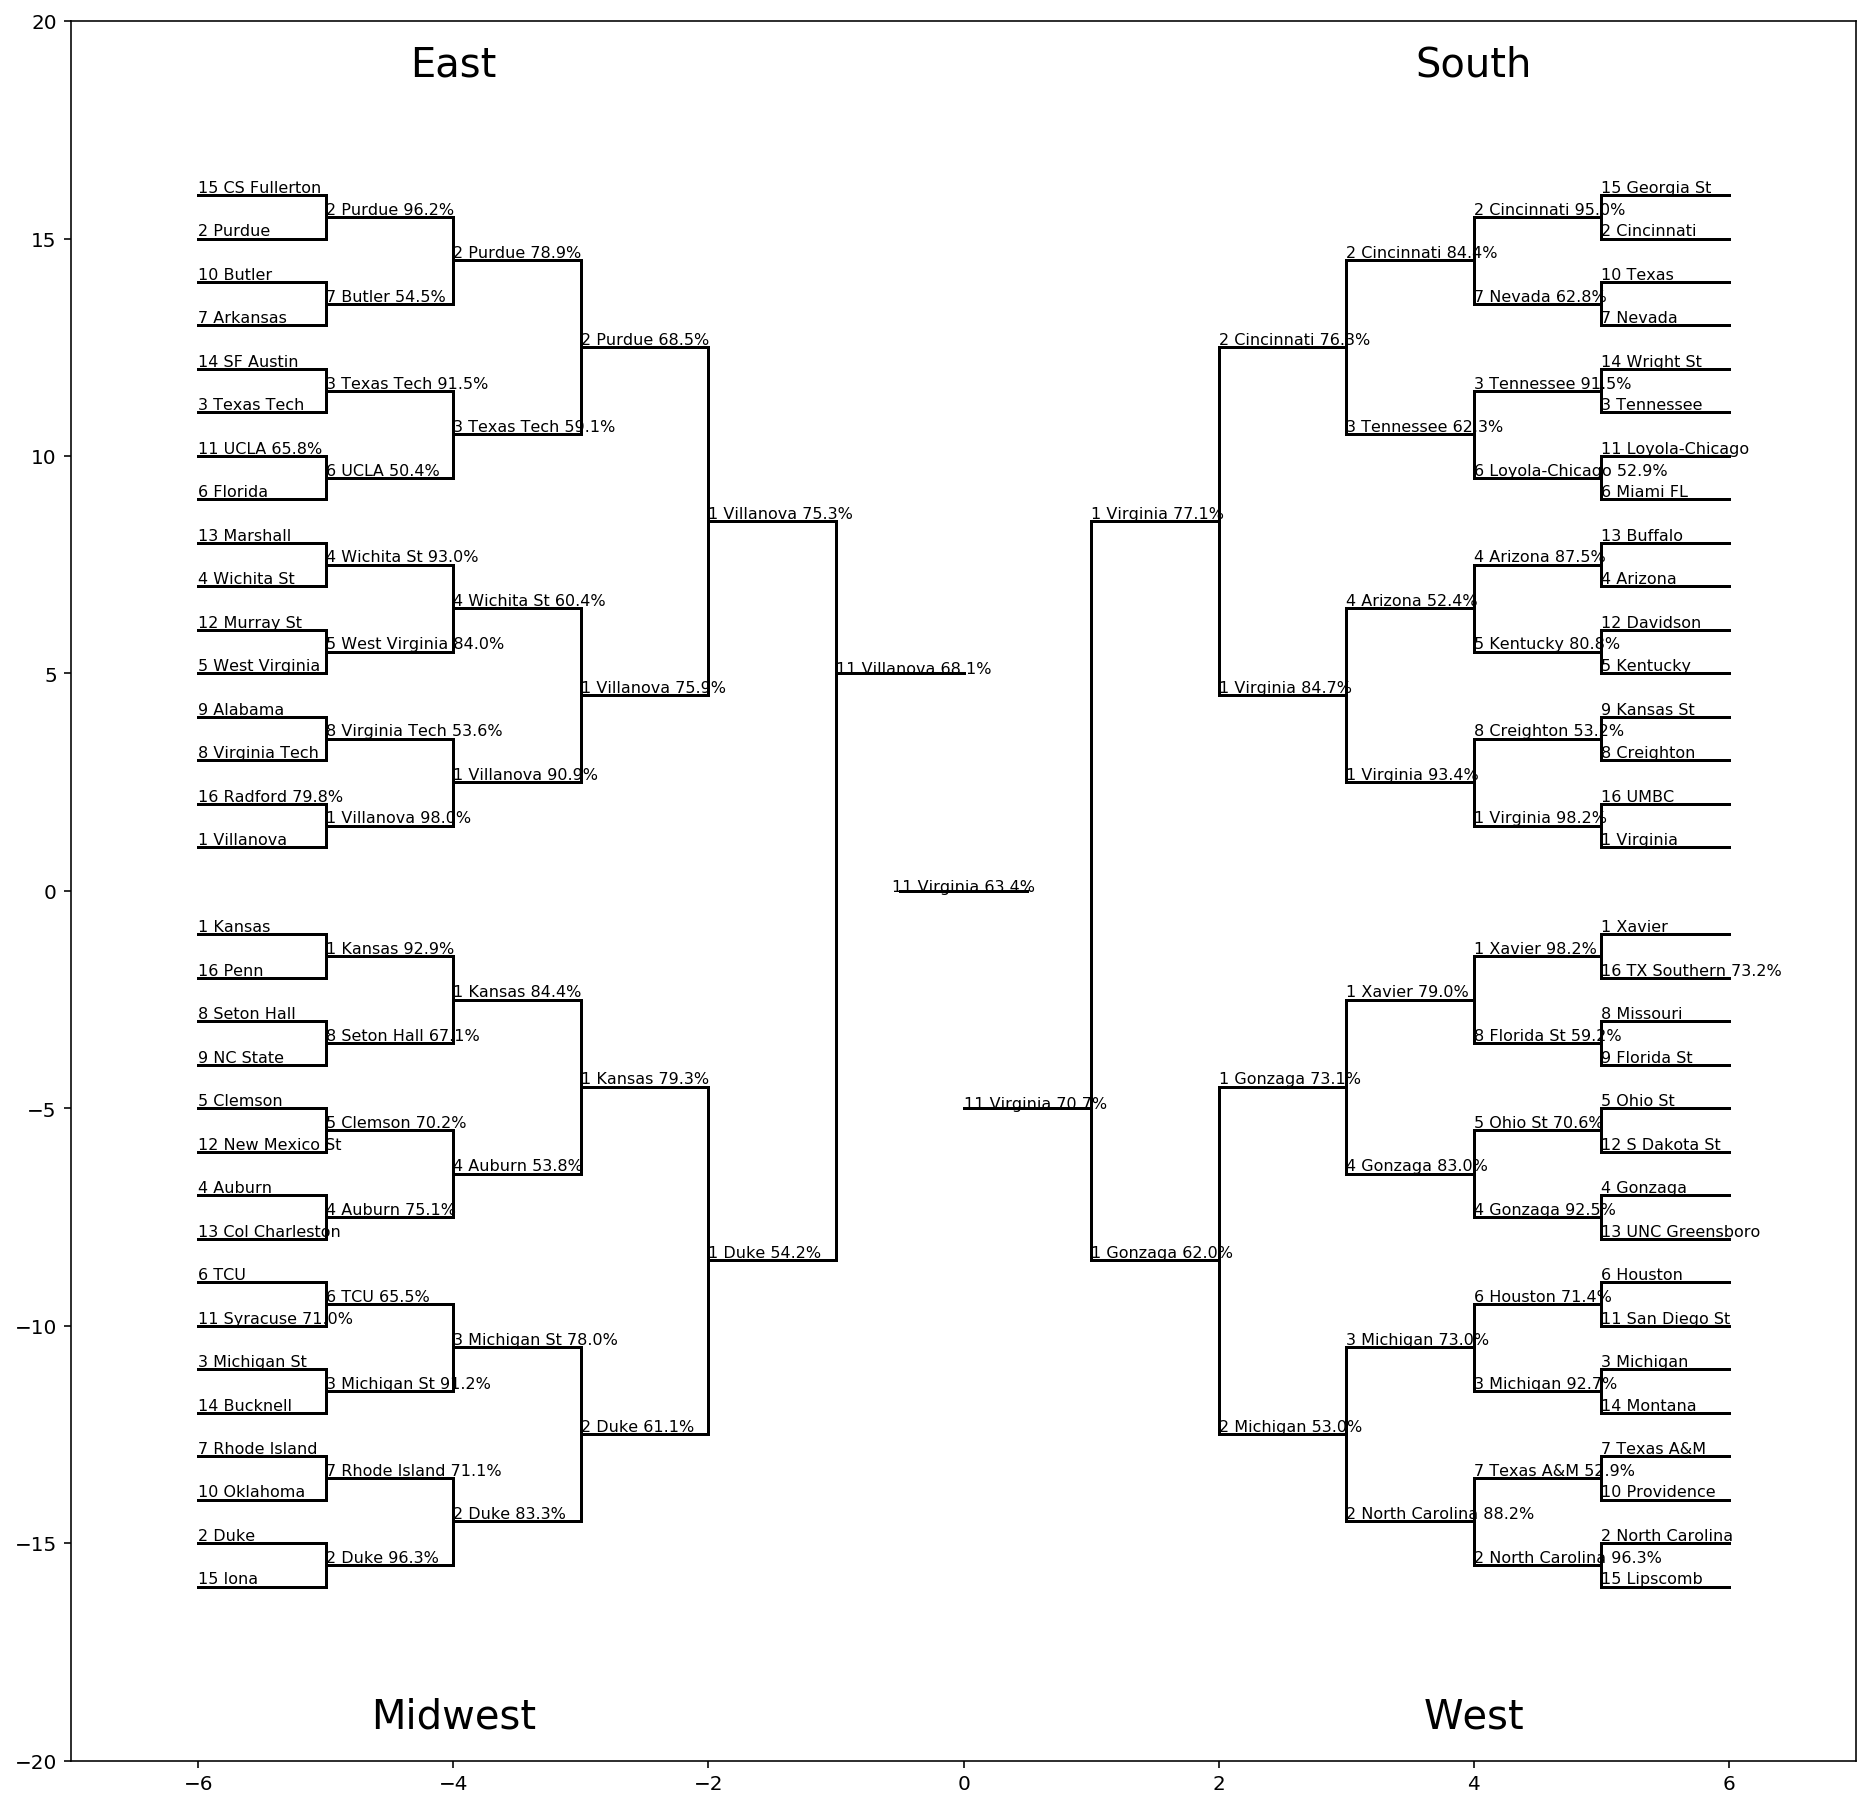

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(16,16))
ax.set_xlim(-7,7)
ax.set_ylim(-20,20)

W = draw_bracket('l','t',seasons.loc[season,'RegionW'],ax)
X = draw_bracket('l','b',seasons.loc[season,'RegionX'],ax)
Y = draw_bracket('r','t',seasons.loc[season,'RegionY'],ax)
Z = draw_bracket('r','b',seasons.loc[season,'RegionZ'],ax)

fill_bracket(bracket,'W',W,'l')
fill_bracket(bracket,'X',X,'l')
fill_bracket(bracket,'Y',Y,'r')
fill_bracket(bracket,'Z',Z,'r')

ax.plot([-1,-1],[-8.5,8.5],'k')
ax.plot([1,1],[-8.5,8.5],'k')

ax.plot([-1,0],[5,5],'k')
b = bracket['R5WX']
ax.text(-1,5,'%d %s %0.1f%%' % (b['Seed'], names.loc[b['Team'],'TeamName'],b['Prob']*100),size=8)

ax.plot([0,1],[-5,-5],'k')
b = bracket['R5YZ']
ax.text(0,-5,'%d %s %0.1f%%' % (b['Seed'], names.loc[b['Team'],'TeamName'],b['Prob']*100),size=8)

ax.plot([-0.5,0.5],[0,0],'k')
b = bracket['R6CH']
ax.text(0,0,'%d %s %0.1f%%' % (b['Seed'], names.loc[b['Team'],'TeamName'],b['Prob']*100),size=8,ha='center')

plt.show()

In [51]:
next_pos[16]

24

In [23]:
for i in range(16):
    b = bracket['W'+str(i+1).zfill(2)]
    x,y = W[get_pos[i+1]]
    print(x,y)

-6 1
-6 15
-6 11
-6 7
-6 5
-6 9
-6 13
-6 3
-6 4
-6 14
-6 10
-6 6
-6 8
-6 12
-6 16
-6 2


In [17]:
get_pos

{1: 1,
 2: 15,
 3: 11,
 4: 7,
 5: 5,
 6: 9,
 7: 13,
 8: 3,
 9: 4,
 10: 14,
 11: 10,
 12: 6,
 13: 8,
 14: 12,
 15: 16,
 16: 2}

In [40]:
bracket

{'W01': 1437,
 'W02': 1345,
 'W03': 1403,
 'W04': 1455,
 'W05': 1452,
 'W06': 1196,
 'W07': 1116,
 'W08': 1439,
 'W09': 1104,
 'W10': 1139,
 'W11a': 1382,
 'W11b': 1417,
 'W12': 1293,
 'W13': 1267,
 'W14': 1372,
 'W15': 1168,
 'W16a': 1254,
 'W16b': 1347,
 'X01': 1242,
 'X02': 1181,
 'X03': 1277,
 'X04': 1120,
 'X05': 1155,
 'X06': 1395,
 'X07': 1348,
 'X08': 1371,
 'X09': 1301,
 'X10': 1328,
 'X11a': 1113,
 'X11b': 1393,
 'X12': 1308,
 'X13': 1158,
 'X14': 1137,
 'X15': 1233,
 'X16': 1335,
 'Y01': 1438,
 'Y02': 1153,
 'Y03': 1397,
 'Y04': 1112,
 'Y05': 1246,
 'Y06': 1274,
 'Y07': 1305,
 'Y08': 1166,
 'Y09': 1243,
 'Y10': 1400,
 'Y11': 1260,
 'Y12': 1172,
 'Y13': 1138,
 'Y14': 1460,
 'Y15': 1209,
 'Y16': 1420,
 'Z01': 1462,
 'Z02': 1314,
 'Z03': 1276,
 'Z04': 1211,
 'Z05': 1326,
 'Z06': 1222,
 'Z07': 1401,
 'Z08': 1281,
 'Z09': 1199,
 'Z10': 1344,
 'Z11': 1361,
 'Z12': 1355,
 'Z13': 1422,
 'Z14': 1285,
 'Z15': 1252,
 'Z16a': 1300,
 'Z16b': 1411,
 'W11': {'Seed': '11',
  'Position': 10,